In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_squared_error

# Product Demand Forecasting

In [2]:
# load restaurant 1
rest1 = pd.read_csv('./archive/restaurant-1-orders.csv', delimiter=',')
print(rest1.head(5))

   Order Number        Order Date            Item Name  Quantity  \
0         16118  03/08/2019 20:25        Plain Papadum         2   
1         16118  03/08/2019 20:25     King Prawn Balti         1   
2         16118  03/08/2019 20:25          Garlic Naan         1   
3         16118  03/08/2019 20:25        Mushroom Rice         1   
4         16118  03/08/2019 20:25  Paneer Tikka Masala         1   

   Product Price  Total products  
0           0.80               6  
1          12.95               6  
2           2.95               6  
3           3.95               6  
4           8.95               6  


In [3]:
# convert oder date to date-time
rest1['Order Date'] = pd.to_datetime(rest1['Order Date'], dayfirst = True)

In [4]:
# Group orders by day and sum total products
rest1_grouped = rest1[['Order Date', 'Quantity']].resample('D', on='Order Date').sum().reset_index()
print(rest1_grouped.head(2))
print(rest1_grouped.tail(2))

  Order Date  Quantity
0 2015-09-01         1
1 2015-09-02         0
     Order Date  Quantity
1431 2019-08-02       132
1432 2019-08-03       162


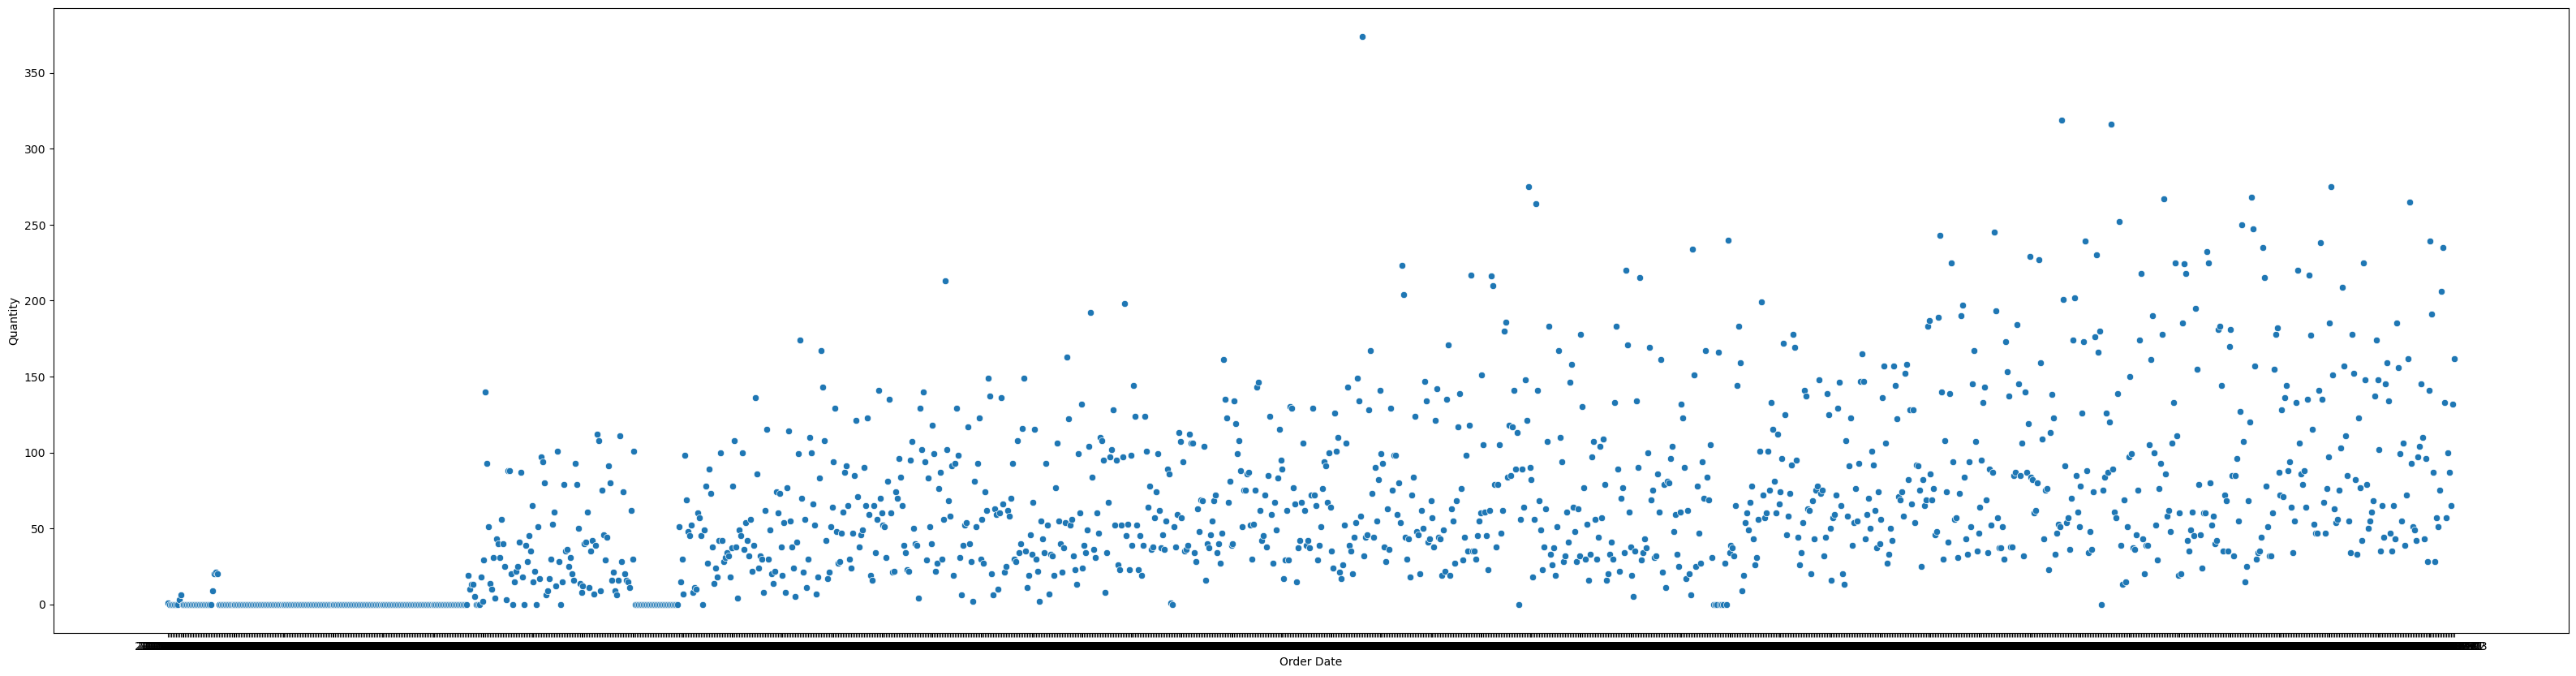

In [7]:
# Plot
times = pd.date_range(start='2015-09-01',end='2019-08-03')
plt.figure(figsize = (40,10))
sns.scatterplot(x = rest1_grouped['Order Date'], y = rest1_grouped['Quantity'])
plt.xticks(times)
plt.show()

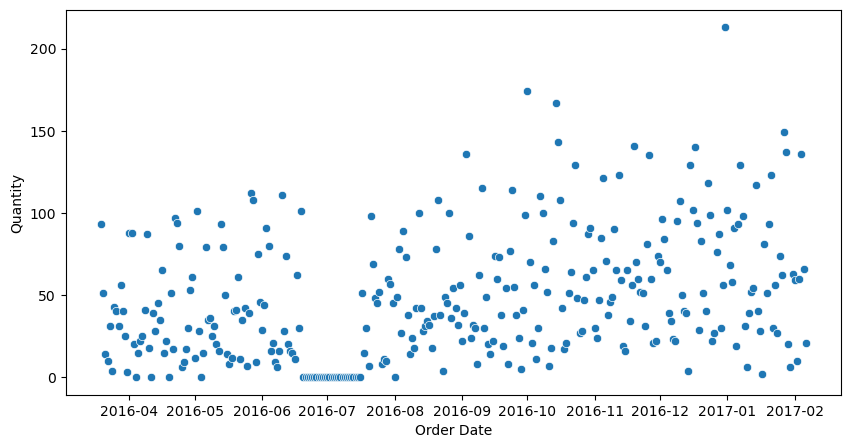

In [10]:
# zoom in
plt.figure(figsize=(10,5))
sns.scatterplot(x = rest1_grouped['Order Date'].iloc[200:525], y = rest1_grouped['Quantity'].iloc[200:525])
plt.show()

In [11]:
orders = rest1_grouped.loc[rest1_grouped['Order Date'] >='2016-08-01' ]

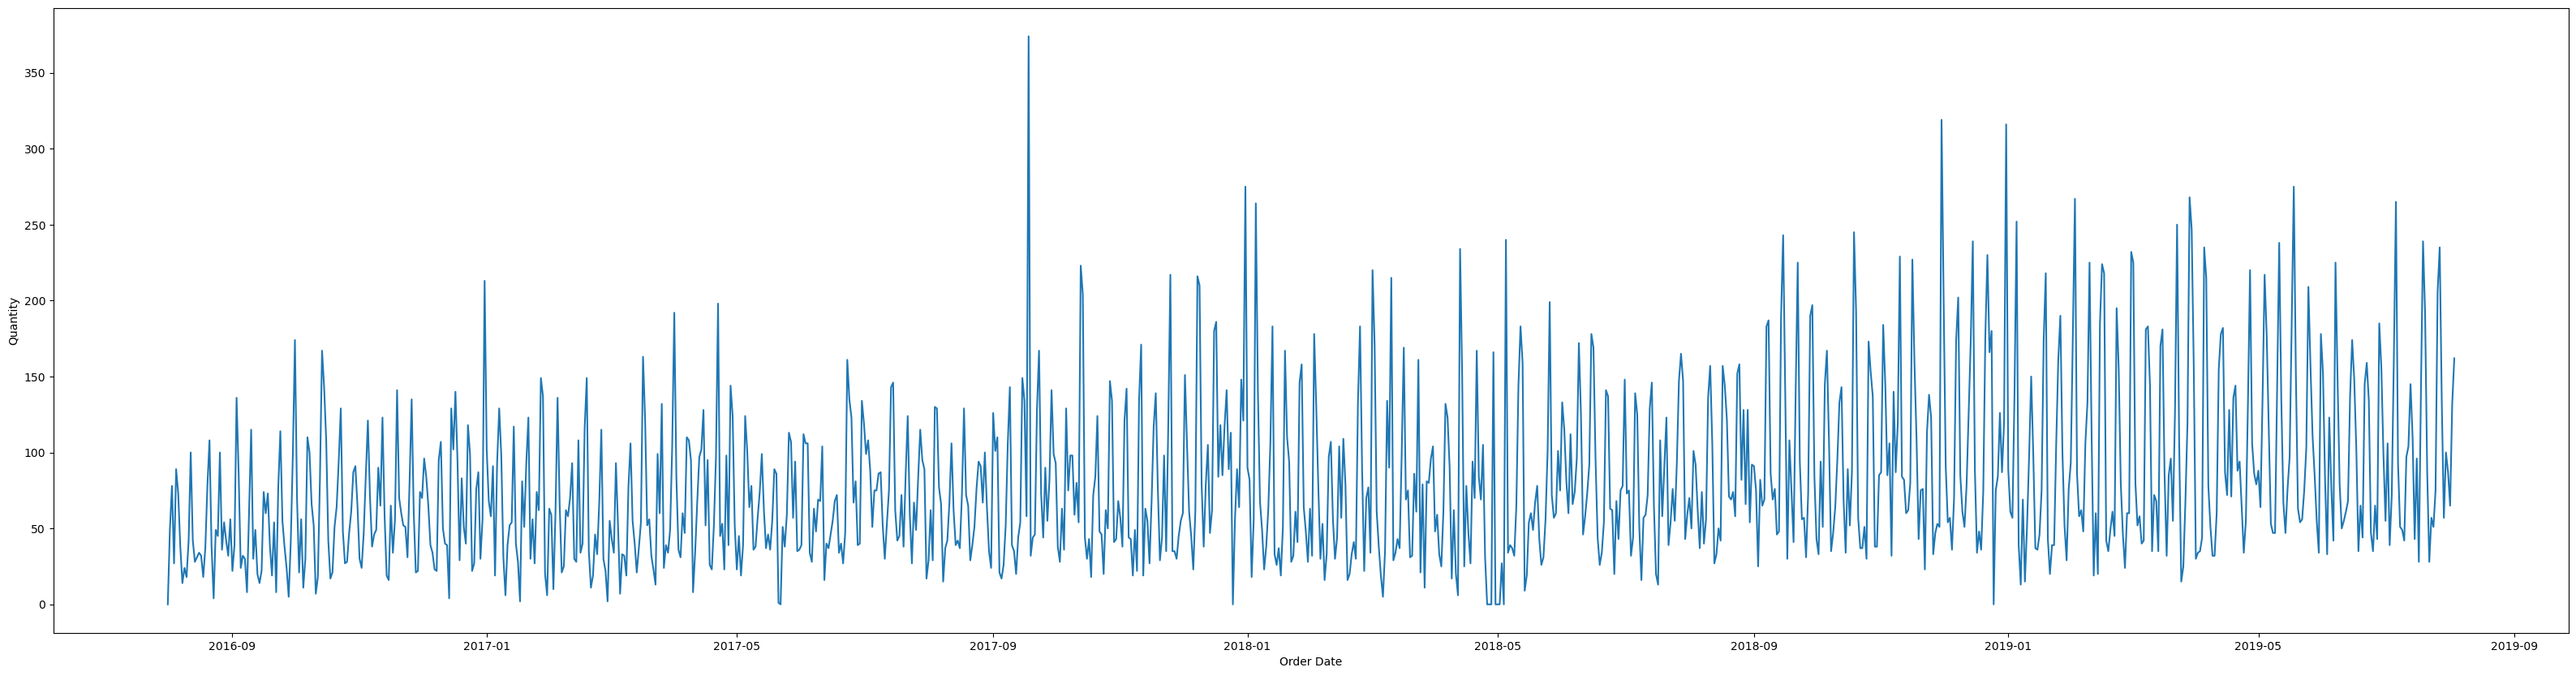

In [17]:
# Plot order data vs quantity sold
plt.figure(figsize = (40,10))
sns.lineplot(x = orders['Order Date'], y = orders['Quantity'])
plt.show()

In [ ]:
# COnvert X to time series
orders.set_index('Order Date', inplace=True)
X = orders['Quantity']

#### Stationarity

In [28]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    #Plot rolling statistics:
    plt.figure(figsize = (40,10))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

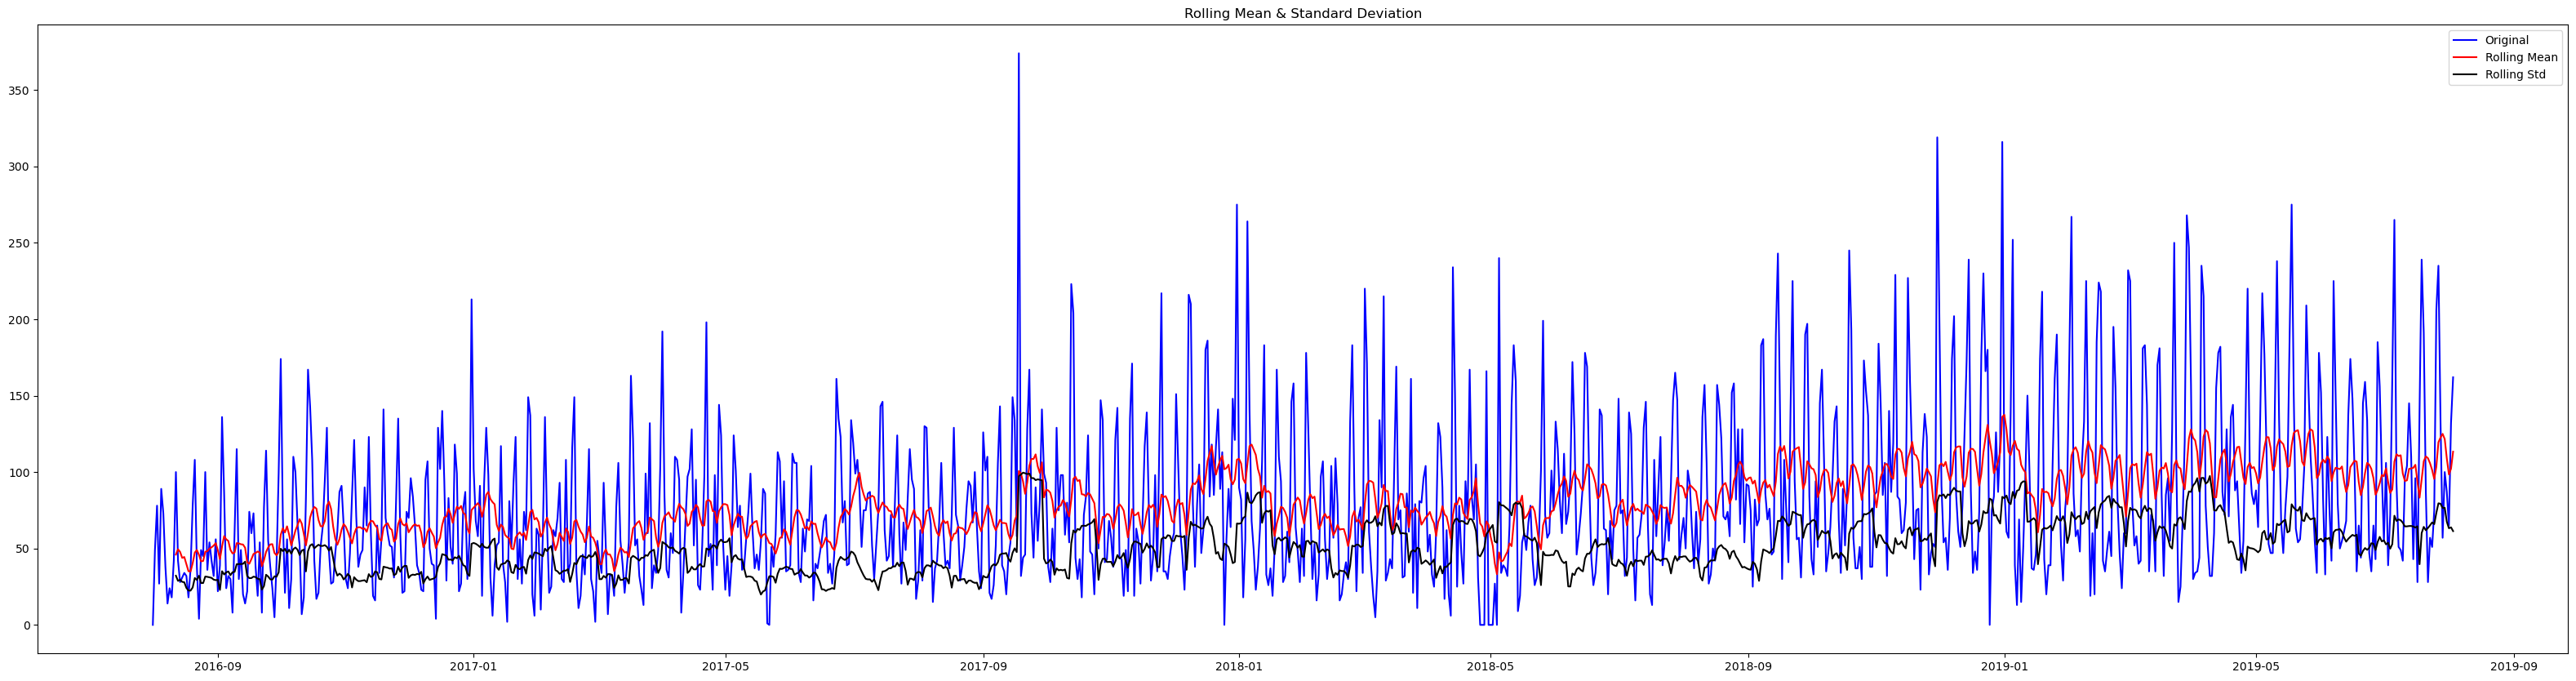

Results of Dickey-Fuller Test:
Test Statistic                   -2.781769
p-value                           0.060925
#Lags Used                       20.000000
Number of Observations Used    1077.000000
Critical Value (1%)              -3.436436
Critical Value (5%)              -2.864227
Critical Value (10%)             -2.568201
dtype: float64


In [29]:
test_stationarity(X)

**Differencing**

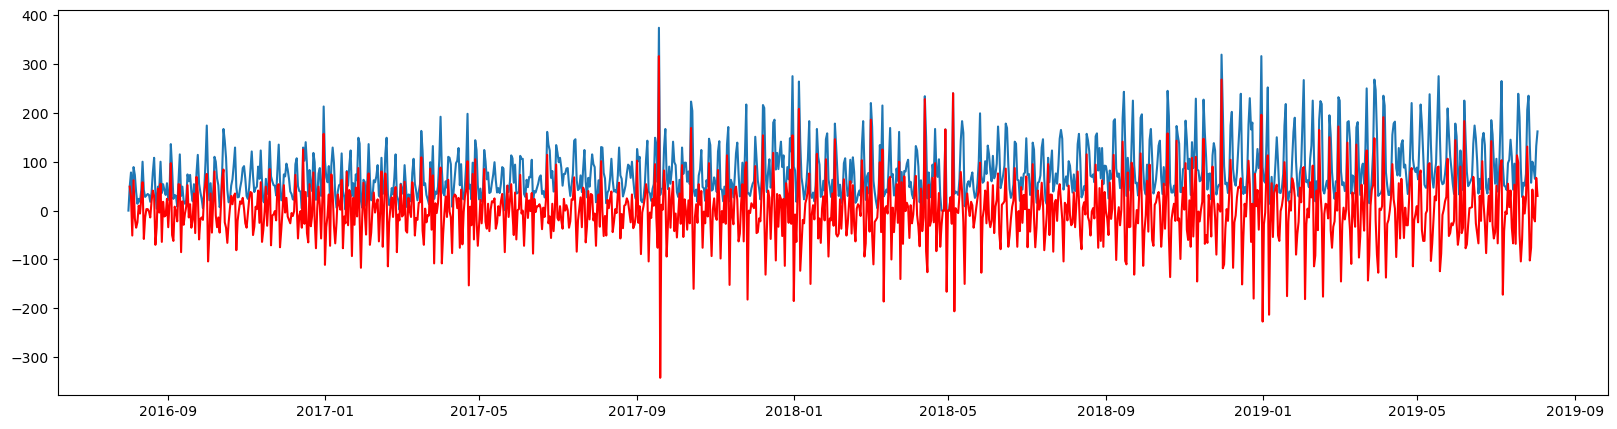

In [68]:
X_diff = X - X.shift()
plt.figure(figsize = (20,5))
plt.plot(X)
plt.plot(X_diff, color='red')
plt.show()

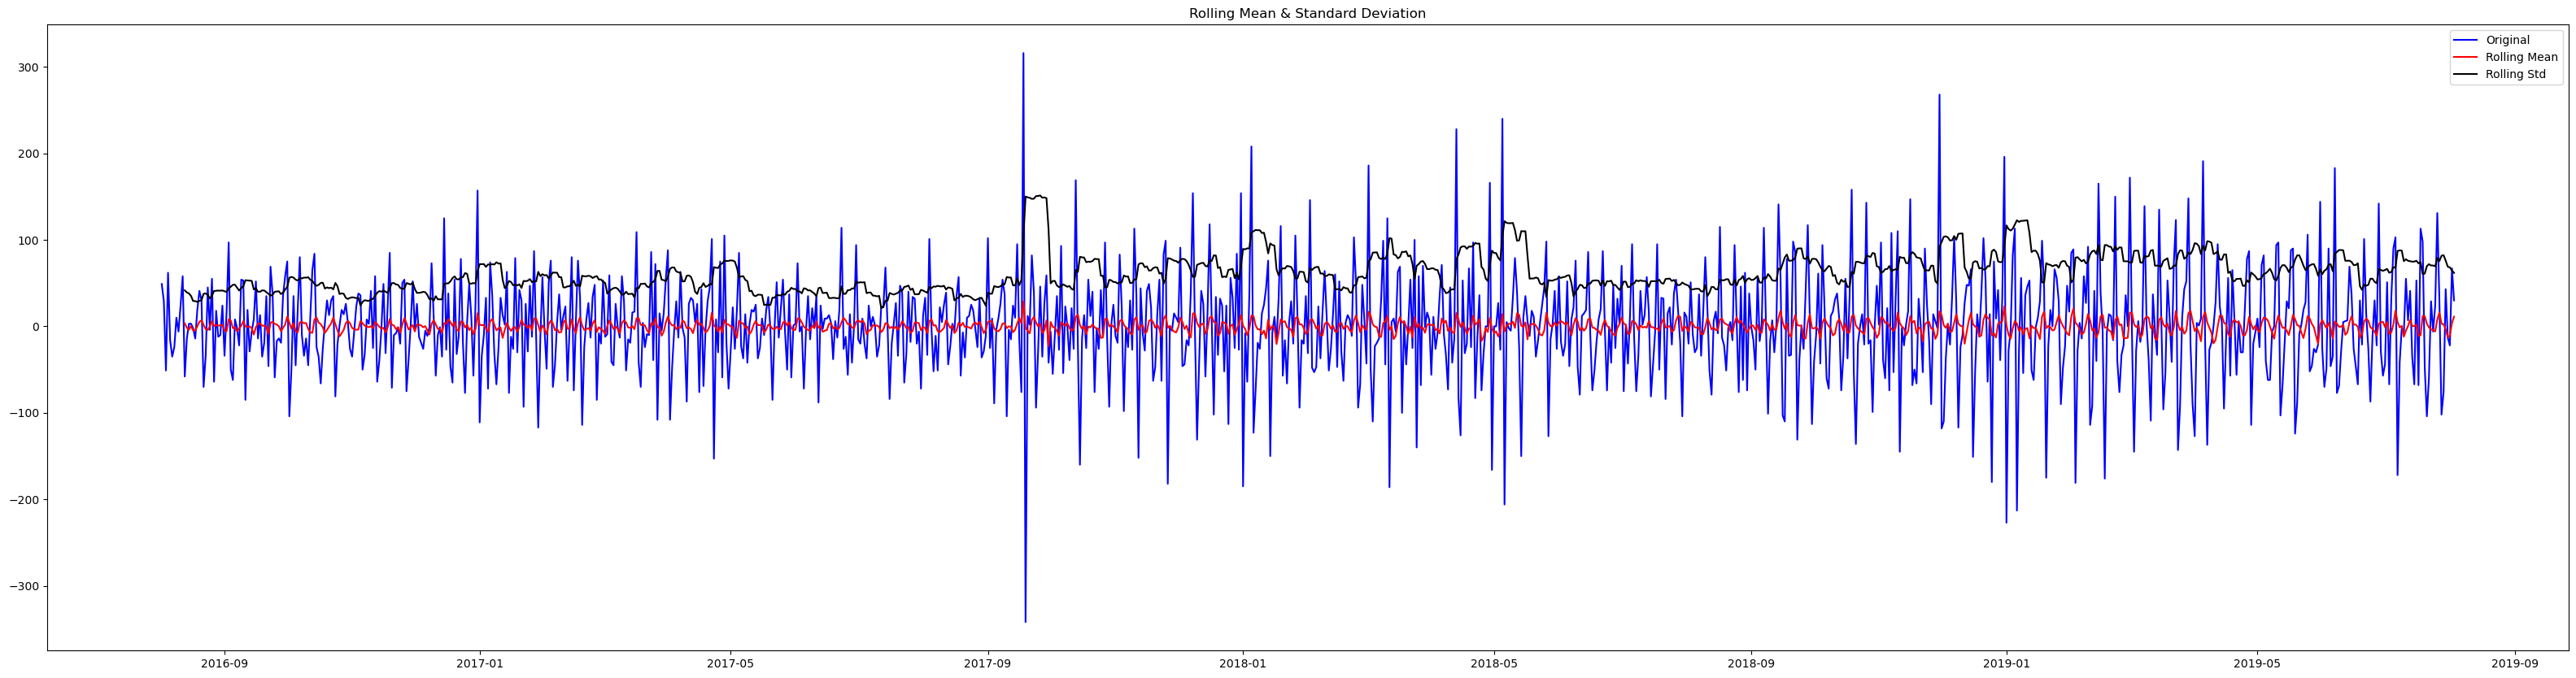

Results of Dickey-Fuller Test:
Test Statistic                -1.450164e+01
p-value                        5.919287e-27
#Lags Used                     1.900000e+01
Number of Observations Used    1.077000e+03
Critical Value (1%)           -3.436436e+00
Critical Value (5%)           -2.864227e+00
Critical Value (10%)          -2.568201e+00
dtype: float64


In [71]:
X_diff.dropna(inplace=True)
test_stationarity(X_diff)

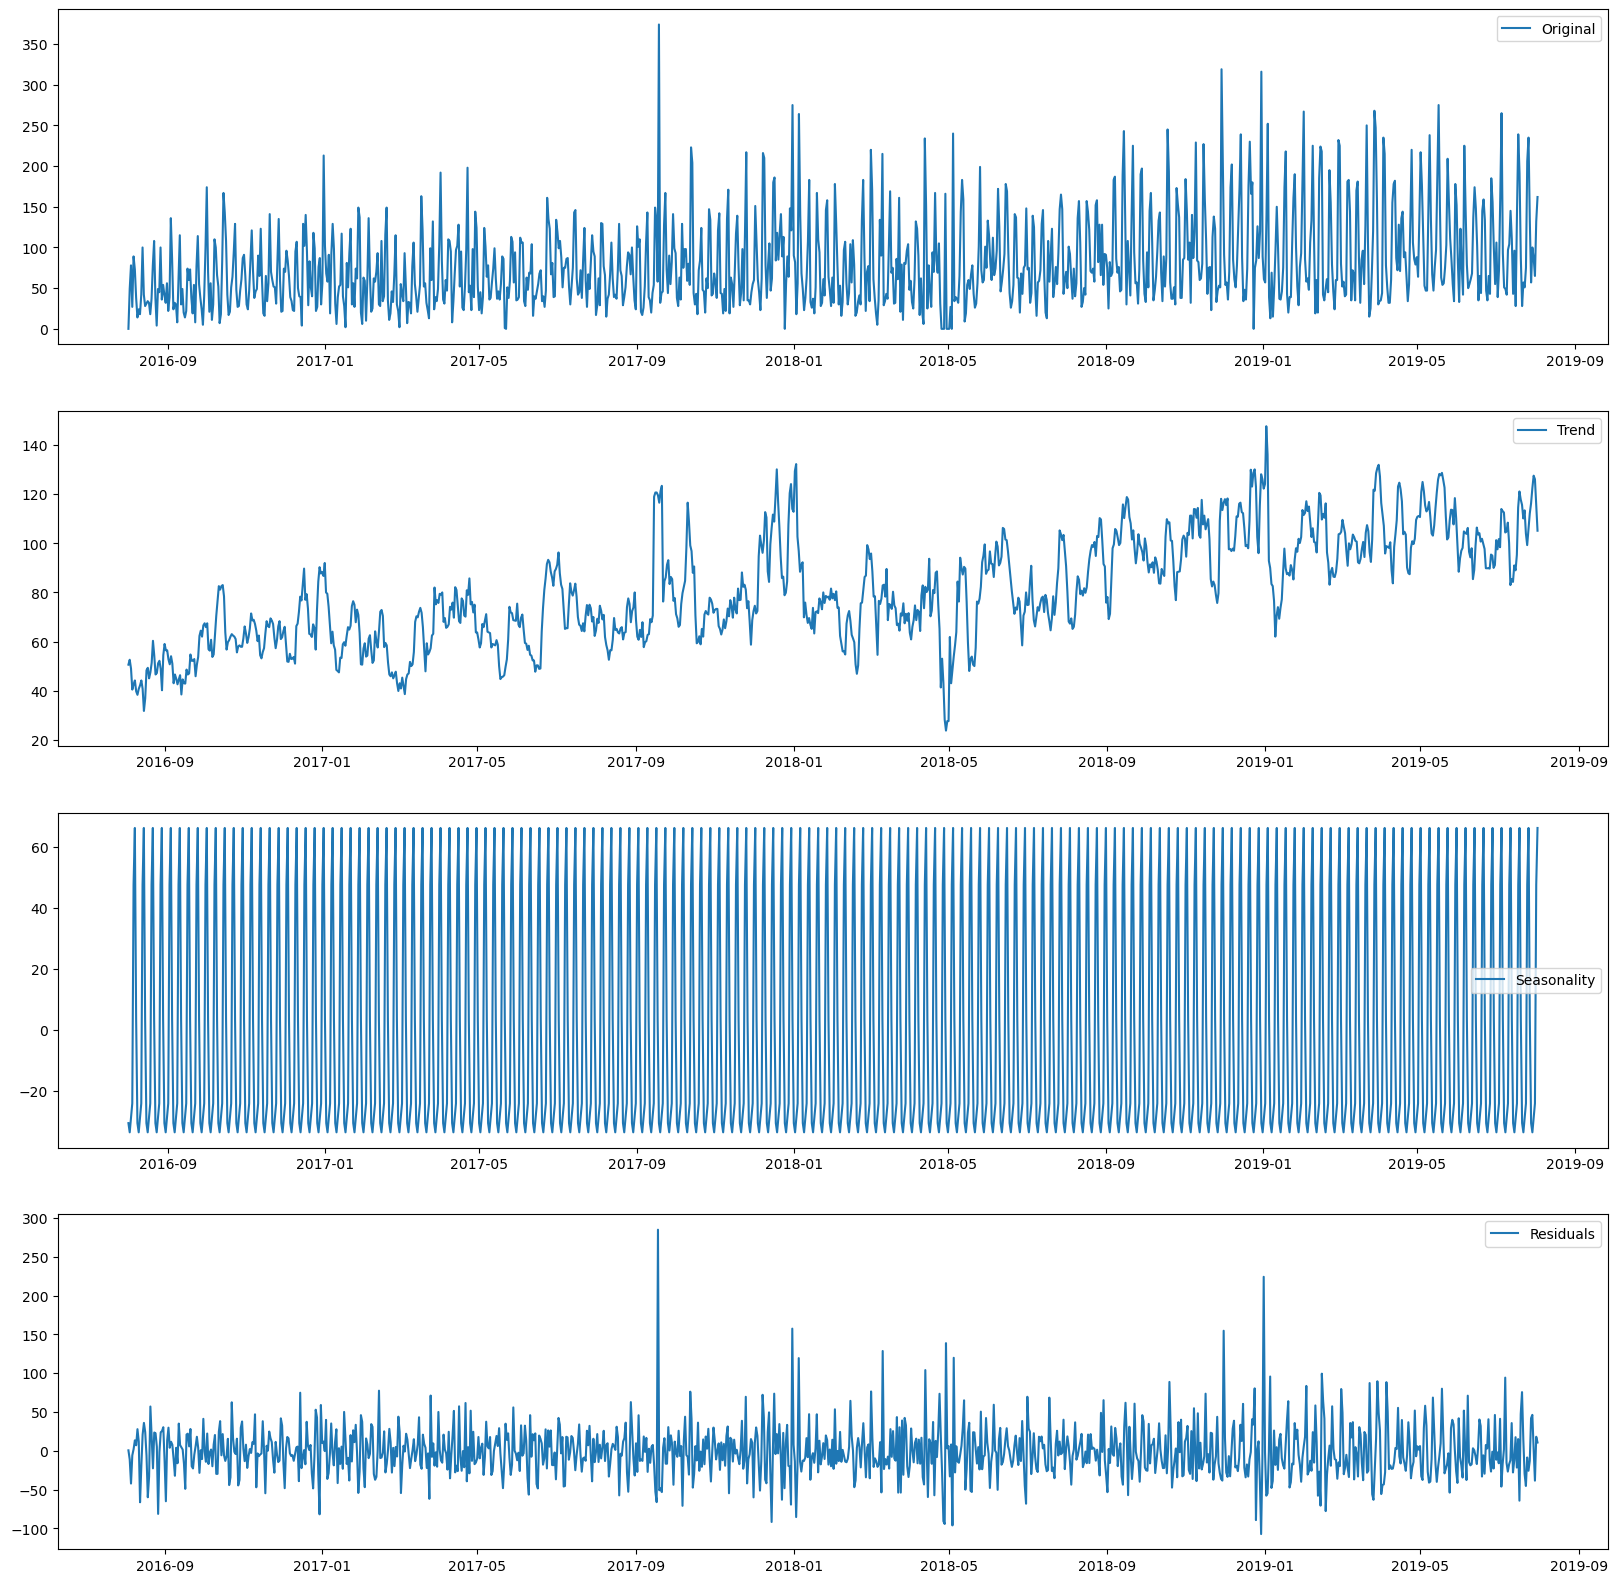

In [46]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(X)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, ax = plt.subplots(4,1, figsize=(20,20))
ax[0].plot(X, label='Original')
ax[0].legend()
ax[1].plot(trend, label='Trend')
ax[1].legend()
ax[2].plot(seasonal, label='Seasonality')
ax[2].legend()
ax[3].plot(residual, label='Residuals')
ax[3].legend()
plt.show()

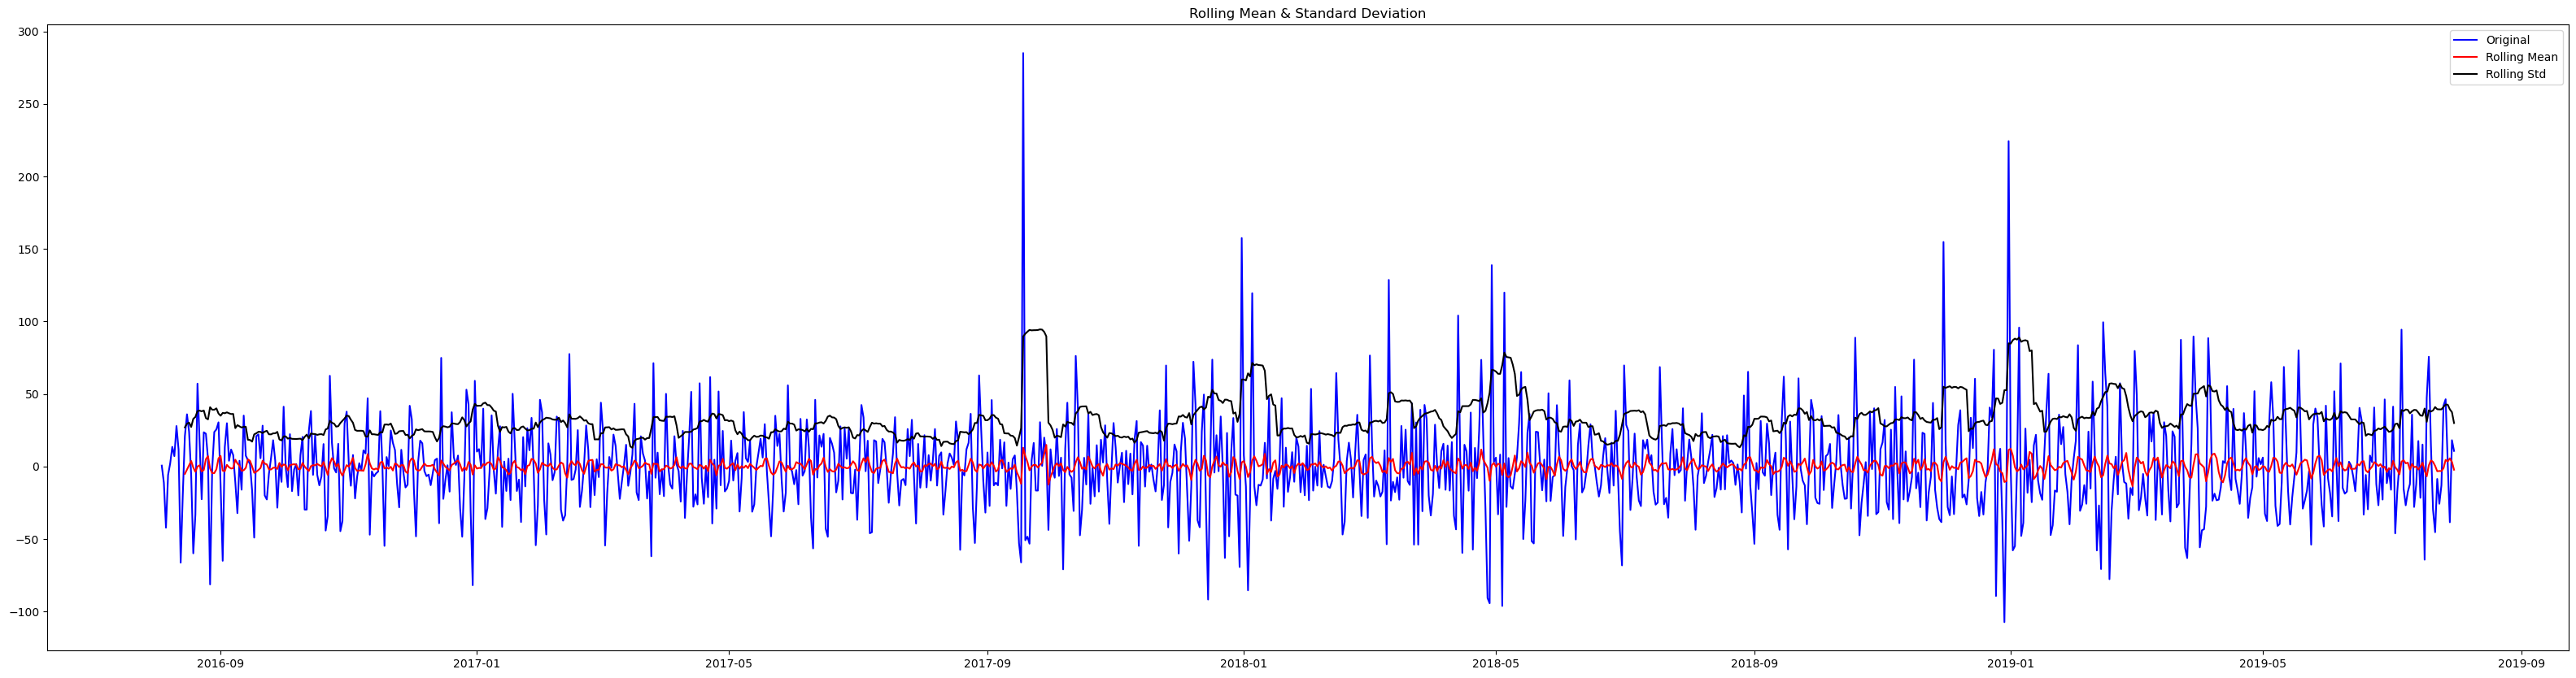

Results of Dickey-Fuller Test:
Test Statistic                -1.427835e+01
p-value                        1.337202e-26
#Lags Used                     2.200000e+01
Number of Observations Used    1.069000e+03
Critical Value (1%)           -3.436482e+00
Critical Value (5%)           -2.864247e+00
Critical Value (10%)          -2.568212e+00
dtype: float64


In [47]:
X_residual = residual
X_residual.dropna(inplace=True)
test_stationarity(X_residual)

### 1. ARIMA

In [83]:
# Train val split
X_train, X_val = X[:880], X[880:]

c:\Users\Jacobie Mouton\Anaconda3\lib\site-packages\statsmodels-0.12.2-py3.7-win-amd64.egg\statsmodels\tsa\stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


Text(0.5, 1.0, 'Partial Autocorrelation Function')

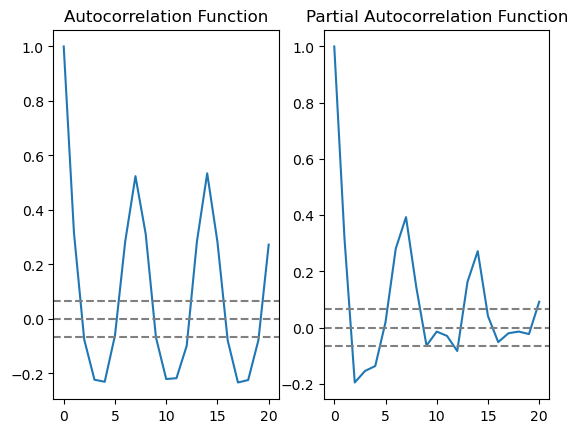

In [84]:
lag_acf = acf(X_train, nlags=20)
lag_pacf = pacf(X_train, nlags=20, method='ols')

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='grey')
plt.axhline(y=-1.96/np.sqrt(len(X_train)), linestyle='--', color='grey')
plt.axhline(y=1.96/np.sqrt(len(X_train)), linestyle='--', color='grey')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='grey')
plt.axhline(y=-1.96/np.sqrt(len(X_train)), linestyle='--', color='grey')
plt.axhline(y=1.96/np.sqrt(len(X_train)), linestyle='--', color='grey')
plt.title('Partial Autocorrelation Function')



c:\Users\Jacobie Mouton\Anaconda3\lib\site-packages\statsmodels-0.12.2-py3.7-win-amd64.egg\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


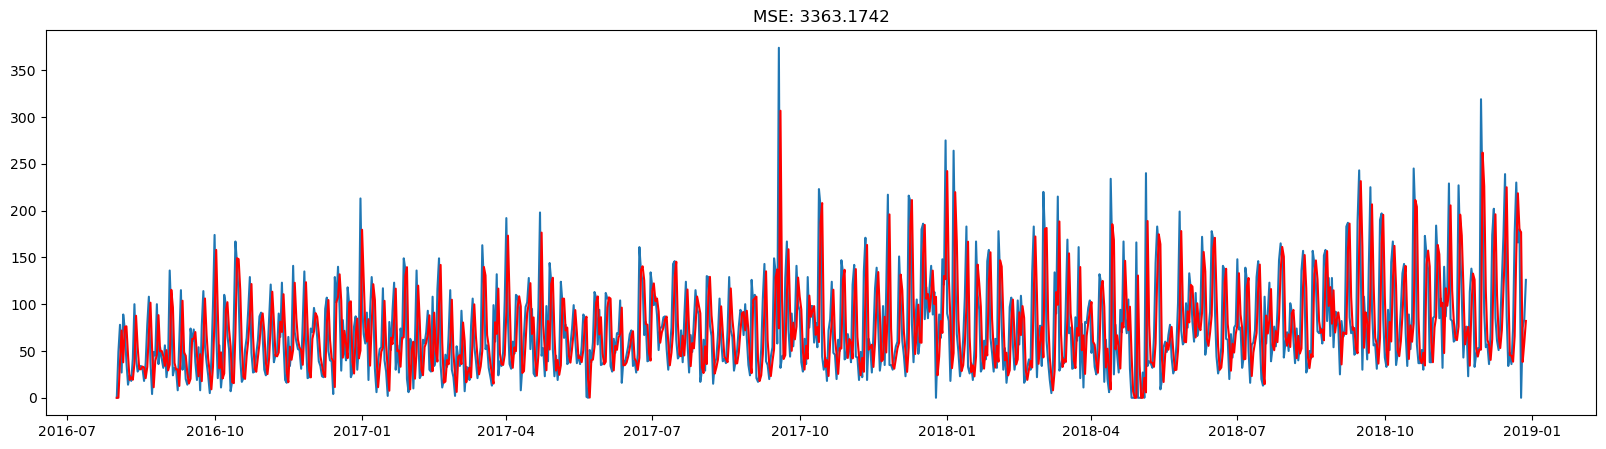

In [85]:
# AR Model
model = ARIMA(X_train, order=(1,1,0), freq='D')
results_AR = model.fit()
plt.figure(figsize = (20,5))
plt.plot(X_train)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('MSE: {:.4f}'.format(np.mean((results_AR.fittedvalues-X_train)**2)))
plt.show()

c:\Users\Jacobie Mouton\Anaconda3\lib\site-packages\statsmodels-0.12.2-py3.7-win-amd64.egg\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
c:\Users\Jacobie Mouton\Anaconda3\lib\site-packages\statsmodels-0.12.2-py3.7-win-amd64.egg\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


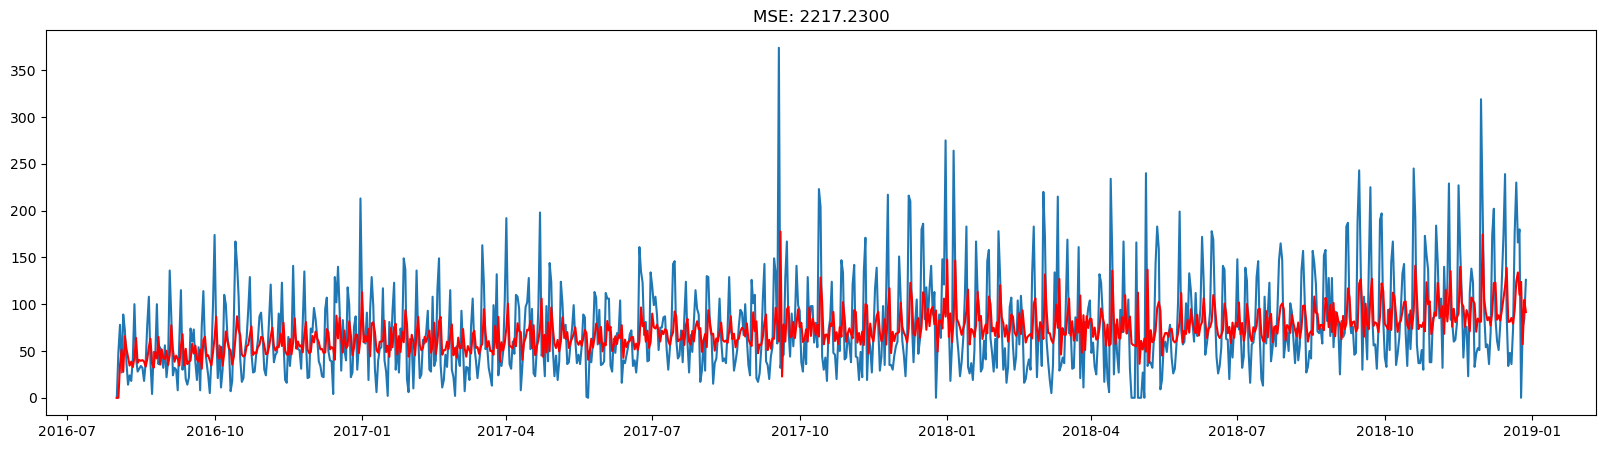

In [87]:
# MA Model
model = ARIMA(X_train, order=(0,1,2), freq='D')
results_MA = model.fit()
plt.figure(figsize = (20,5))
plt.plot(X_train)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('MSE: {:.4f}'.format(np.mean((results_MA.fittedvalues-X_train)**2)))
plt.show()

c:\Users\Jacobie Mouton\Anaconda3\lib\site-packages\statsmodels-0.12.2-py3.7-win-amd64.egg\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
c:\Users\Jacobie Mouton\Anaconda3\lib\site-packages\statsmodels-0.12.2-py3.7-win-amd64.egg\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


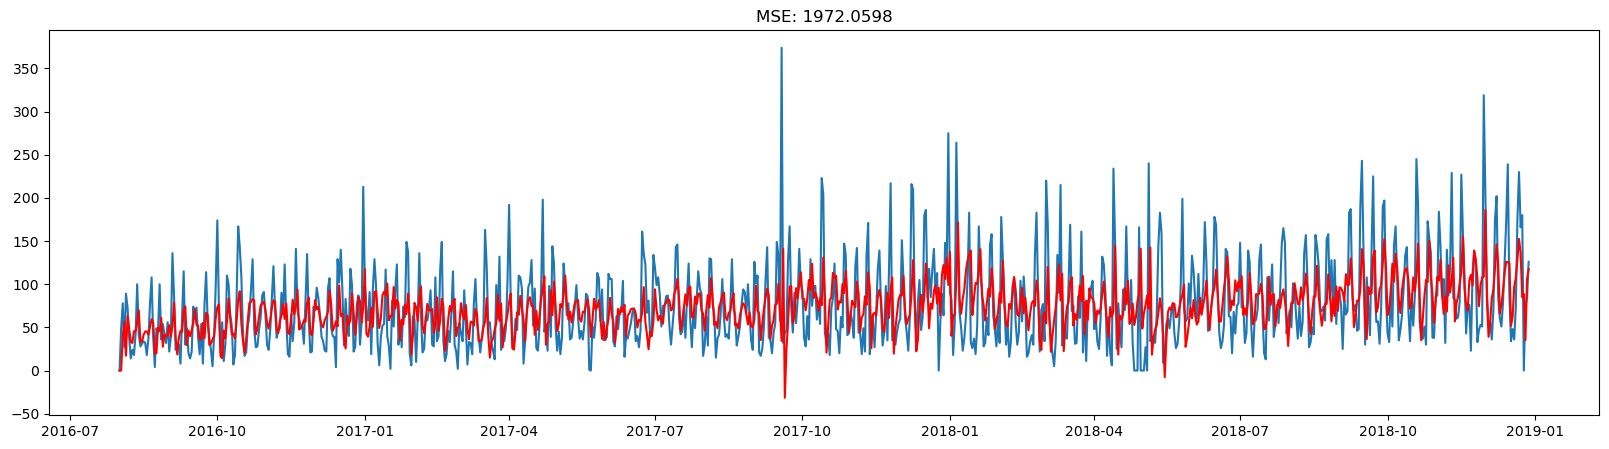

In [89]:
# ARIMA Model
model = ARIMA(X_train, order=(2,1,2), freq='D')
results_ARIMA = model.fit()
plt.figure(figsize = (20,5))
plt.plot(X_train)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('MSE: {:.4f}'.format(np.mean((results_ARIMA.fittedvalues-X_train)**2)))
plt.show()

In [90]:
print(results_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:               Quantity   No. Observations:                  880
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -4582.766
Date:                Fri, 07 Oct 2022   AIC                           9175.531
Time:                        15:54:52   BIC                           9199.425
Sample:                    08-01-2016   HQIC                          9184.669
                         - 12-28-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8925      0.052     17.307      0.000       0.791       0.994
ar.L2         -0.4666      0.029    -16.285      0.000      -0.523      -0.410
ma.L1         -1.6022      0.053    -30.119      0.0

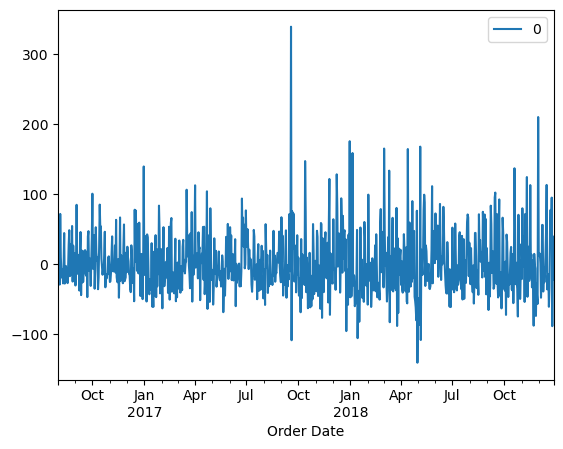

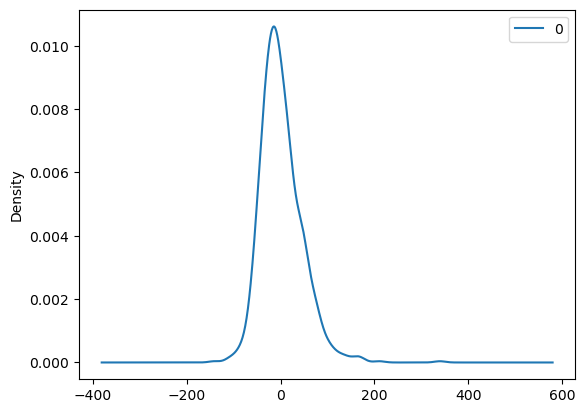

In [92]:
# line plot of residuals
residuals = pd.DataFrame(results_ARIMA.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()

c:\Users\Jacobie Mouton\Anaconda3\lib\site-packages\statsmodels-0.12.2-py3.7-win-amd64.egg\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Jacobie Mouton\Anaconda3\lib\site-packages\statsmodels-0.12.2-py3.7-win-amd64.egg\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


predicted=131.726314, expected=87.000000
predicted=109.488267, expected=120.000000
predicted=122.666398, expected=316.000000
predicted=172.986764, expected=89.000000
predicted=51.122199, expected=61.000000
predicted=73.257065, expected=57.000000
predicted=98.681615, expected=139.000000
predicted=138.870065, expected=252.000000
predicted=158.951720, expected=39.000000
predicted=61.031174, expected=13.000000
predicted=89.897928, expected=69.000000
predicted=133.724423, expected=15.000000
predicted=117.607778, expected=51.000000
predicted=139.345122, expected=97.000000
predicted=147.145372, expected=150.000000
predicted=145.119379, expected=99.000000
predicted=104.944865, expected=37.000000
predicted=85.038494, expected=36.000000
predicted=99.167849, expected=46.000000
predicted=109.008058, expected=75.000000
predicted=116.882977, expected=174.000000
predicted=137.337750, expected=218.000000
predicted=119.373409, expected=43.000000
predicted=37.362154, expected=20.000000
predicted=61.5442

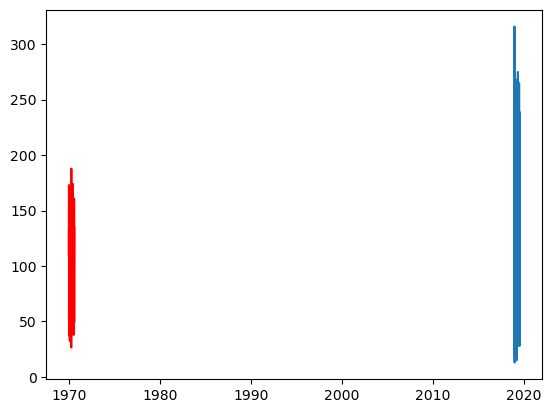

In [95]:
# Forecasting
history = [x for x in X_train]
predictions = list()
# walk-forward validation
for t in range(X_val.shape[0]):
	model = ARIMA(history, order=(2,1,2))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = X_val[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(X_val, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(X_val)
plt.plot(predictions, color='red')
plt.show()

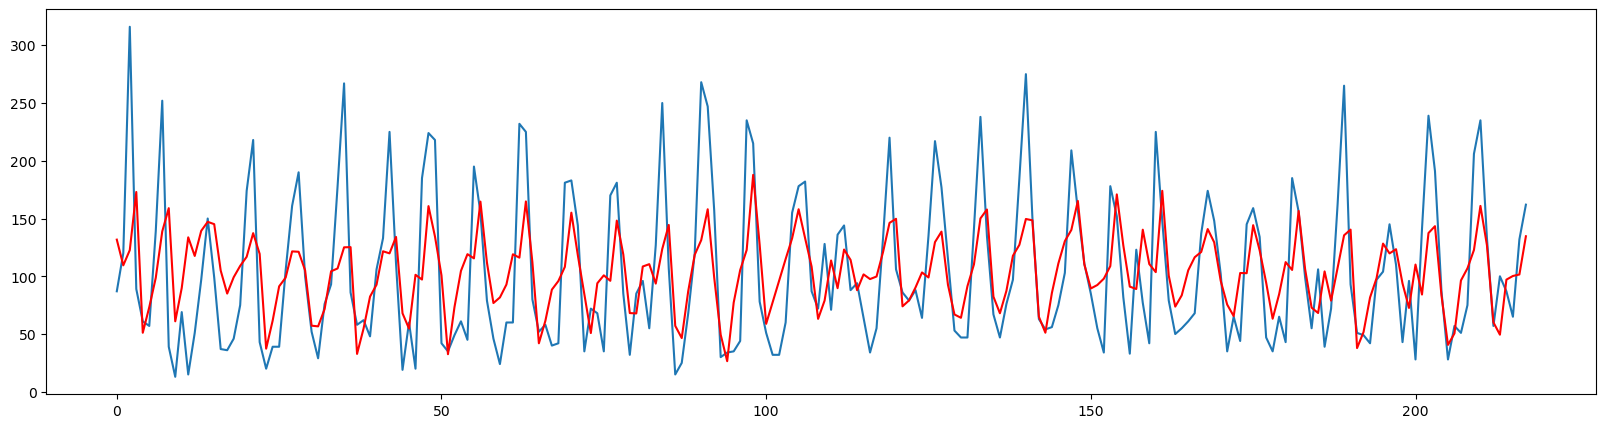

In [97]:
plt.figure(figsize=(20,5))
plt.plot(np.array(X_val))
plt.plot(np.array(predictions), color='red')
plt.show()